In [1]:
import os, random
import pandas as pd
import numpy as np
import itertools, cv2
import seaborn as sns
sns.set_style('darkgrid')

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, LayerNormalization, Flatten, BatchNormalization, Dropout, GaussianNoise, Conv2D, GaussianDropout
from tensorflow.keras.applications.imagenet_utils import decode_predictions

2024-04-21 09:26:04.730191: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 09:26:04.730255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 09:26:04.731805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset_name = "fracturefusion"
dataset_paths = [
    '/kaggle/input/fracturefusion-a-symphony-of-bone-breaks'
]

In [3]:
HIDDEN_LAYERS = [512,128]
USE_HIDDEN_LAYERS = True
PIC_SIZE = (224, 224)
INPUT_SHAPE = (*PIC_SIZE, 3)
BATCH_SIZE = 16
EPOCHS = 100

In [4]:
from collections import defaultdict

count_dist = defaultdict(int)
original_images = []
labels = []

# Spliting by my self later
for path in dataset_paths:
    for dirpath, _, filenames in os.walk(path):
        for filename in filenames:
            image = cv2.imread(os.path.join(dirpath, filename))
            image = cv2.resize(image, PIC_SIZE, interpolation = cv2.INTER_AREA)
            image = cv2.addWeighted(image, 1.5, image, -0.15,-0.15)            
            label = dirpath.split('/')[-1]
            
            if label in ["Avulsion fracture","Comminuted fracture","Fracture Dislocation","Greenstick fracture","Hairline Fracture"]: continue
            count_dist[label] += 1
            original_images.append(image)
            labels.append(label)
len(original_images), len(labels)

(469, 469)

In [5]:
img_augmentation_layers = [
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.1),
]

def img_augmentation(images, k=2):
    results = []
    for i in range(k):
        x = images
        for layer in img_augmentation_layers:
            x = layer(x)
        results.extend(x)
    
    return results

In [6]:
data_dict = defaultdict(list)
aug_dict = defaultdict(list)

for i, img in enumerate(original_images):
    data_dict[labels[i]].append(img)

for k, _images in data_dict.items():
    aug_dict[k] = img_augmentation(_images, k=8)

all_images = original_images
all_labels = labels
for label, items in aug_dict.items():
    size = len(items)
    aug_labels = [label for i in range(size)]
    all_images.extend(items)
    all_labels.extend(aug_labels)

original_images=all_images
labels=all_labels
len(original_images), len(labels)

(4221, 4221)

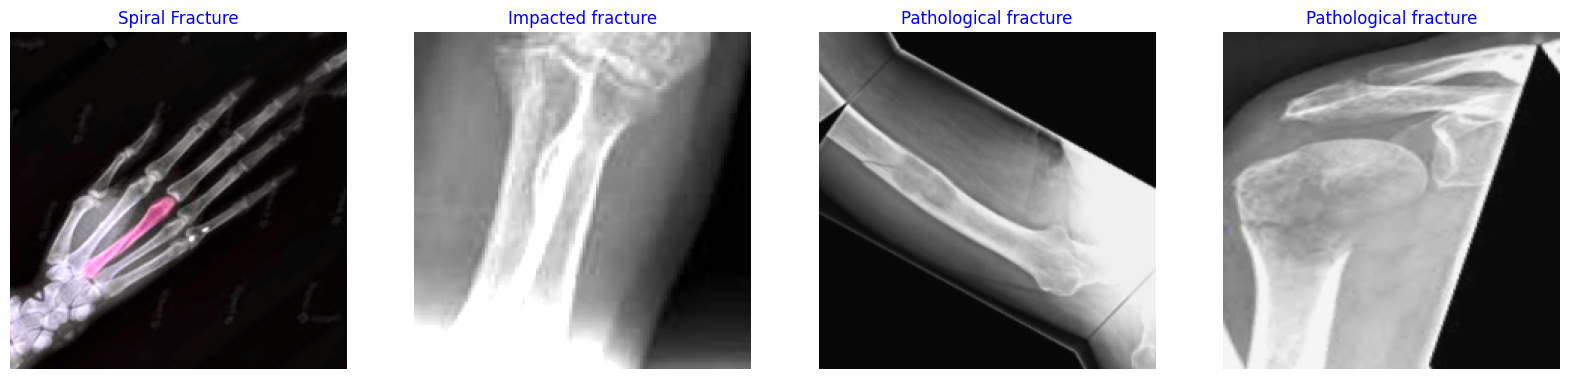

In [7]:
def visualize_datasets(images, labels, k=4, seed=42):
    # visualize datasets
    plt.figure(figsize=(20, 20))
    random.seed(seed)
    samples = random.sample(list(range(len(images))), k)
    for stt, i in enumerate(samples):
        plt.subplot(2, k, stt + 1)
        plt.imshow(images[i] / 255)
        class_name = labels[i]
        plt.title(class_name, color = 'blue' , fontsize=12)
        plt.axis('off')

    plt.show()

images = original_images
visualize_datasets(images, labels)

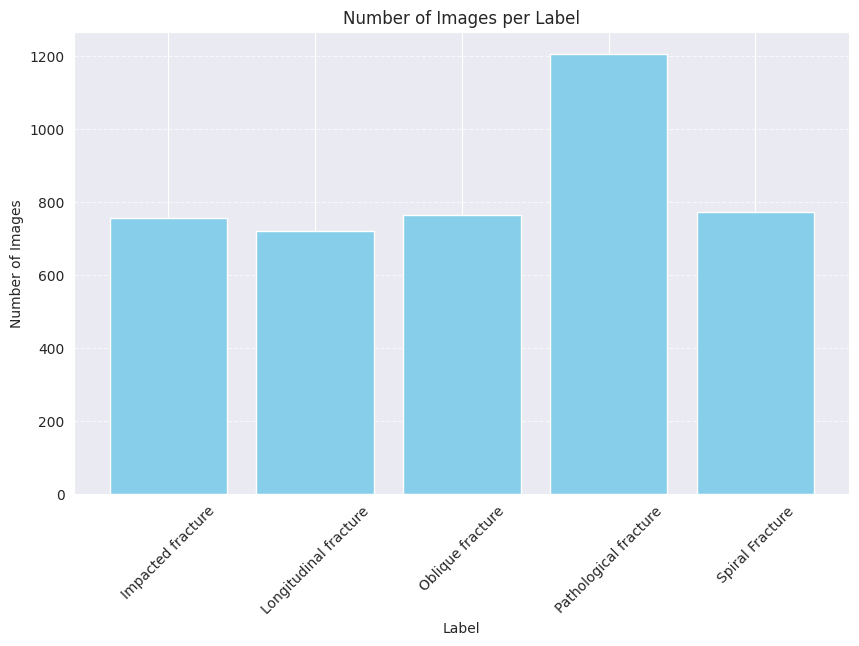

In [8]:
def visualize_datasets(images, labels):
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, color='skyblue')
    plt.title('Number of Images per Label')
    plt.xlabel('Label')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Example usage:
visualize_datasets(images, labels)

In [9]:
classes = sorted(set(labels))
label_dict = { v: i for i, v in enumerate(classes) }
classes, label_dict

(['Impacted fracture',
  'Longitudinal fracture',
  'Oblique fracture',
  'Pathological fracture',
  'Spiral Fracture'],
 {'Impacted fracture': 0,
  'Longitudinal fracture': 1,
  'Oblique fracture': 2,
  'Pathological fracture': 3,
  'Spiral Fracture': 4})

In [10]:
# Convert labels to numpy array
images = np.stack(images, axis=0)
labels = np.array([label_dict[label] for label in labels])

images.shape, labels.shape, labels[:20]

((4221, 224, 224, 3),
 (4221,),
 array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0]))

In [11]:
def count_labels(labels):
    count_dict = defaultdict(int)
    for label in labels:
        count_dict[label] += 1
    return count_dict

In [12]:
# Split the data into training and remaining sets (validation + test)
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, stratify=labels)
# Split the remaining data into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp)

[
    x_train.shape, 
    x_val.shape, 
    x_test.shape, 
    y_train.shape , 
    y_val.shape , 
    y_test.shape, 
    count_labels(y_train),
    count_labels(y_val),
    count_labels(y_test), 
]

[(3376, 224, 224, 3),
 (422, 224, 224, 3),
 (423, 224, 224, 3),
 (3376,),
 (422,),
 (423,),
 defaultdict(int, {4: 619, 1: 576, 3: 964, 0: 605, 2: 612}),
 defaultdict(int, {1: 72, 2: 76, 3: 121, 0: 76, 4: 77}),
 defaultdict(int, {1: 72, 4: 78, 3: 121, 0: 75, 2: 77})]

In [13]:
def plot_acc(model_history, epochs, name):
    print('\n\n')
    plt.figure(figsize=(12,8))
    plt.plot(np.arange(0, epochs), model_history.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), model_history.history["val_accuracy"], label="val_acc")
    plt.title("Training Accuracy - {}".format(name))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [14]:
def plot_loss(model_history, epochs, name):
    print('\n\n')
    plt.figure(figsize=(12,8))
    plt.plot(np.arange(0, epochs), model_history.history["loss"], label="train_loss", )
    plt.plot(np.arange(0, epochs), model_history.history["val_loss"], label="val_loss")
    plt.title("Training Loss - {}".format(name))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [15]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plot the confusion matrix
    class_count = len(classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    row_sums = cm.sum(axis=1)
    cm = cm / row_sums[:, np.newaxis]
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='.2%', cmap='Blues', cbar=False)       
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

In [16]:
def predict(model):
    print('\nPredicting test set classes.')
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Test set score:', scores)
    predictions = model.predict(x_test, batch_size=BATCH_SIZE, verbose=1)
    print('Done.')
    return np.argmax(predictions, axis=1)

In [17]:
def calculate_metrics(y_true, y_pred):
    
    print("Visualize: y_true, y_pred top 20")
    print('Y_true', [i for i in y_true[:20]])
    print('Y_pred', [j for j in y_pred[:20]])
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_pred)
    print("ACC:       {}".format(accuracy))

    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred, average='weighted')
    print("Precision: {}".format(precision))

    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred, average='weighted')
    print("Recall:    {}".format(recall))

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print("F1:        {}".format(f1))
    

In [18]:
def transfer_learning(model, name):
    
    best_weights_ph1 = f"{dataset_name}_{name}_ph1_weights.keras"
    callbacks_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = best_weights_ph1,
        monitor = "val_accuracy",
        mode = "max",
        save_weights_only=True,
        save_best_only = True,
        verbose=1, # Logging when callback running
    )
    callbacks_earlystoping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=30,
        verbose=1,
        mode='max',
        baseline=None,
        restore_best_weights=False,
        start_from_epoch=0
    )
    
    history = model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        validation_batch_size=BATCH_SIZE,
        epochs = EPOCHS,
        callbacks = [callbacks_checkpoint]
    )
    
    best_acc_ph1 = max(history.history["val_accuracy"])
    print('\n\nMax validation accuracy:', best_acc_ph1)

    print('\nRestoring best weights and predicting validation set.')
    model.load_weights(best_weights_ph1)
    y_pred = predict(model)
    
    plot_acc(history, EPOCHS, f"\n Transfer Learning - ACC: {name} PhA.")
    plot_loss(history, EPOCHS, f"\n Transfer Learning - LOSS: {name} PhA.")
    
    return history, model, best_acc_ph1, y_pred

In [19]:
def fine_turning(model, name, best_acc_ph1):
    
    best_weights_ph2 = f"{dataset_name}_{name}_ph2_weights.keras"
    callbacks_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = best_weights_ph2,
        monitor = "val_accuracy",
        mode = "max",
        save_weights_only=True,
        save_best_only = True,
        verbose=1, # Logging when callback running
    )
    callbacks_earlystoping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=30,
        verbose=1,
        mode='max',
        baseline=None,
        restore_best_weights=False,
        start_from_epoch=0
    )
    
    for layer in model.layers[-20:]:
         if not isinstance(layer, LayerNormalization):
            layer.trainable = True

    #model.trainable = True
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(
        x_train,
        y_train,
        batch_size=BATCH_SIZE,
        validation_data=(x_val, y_val),
        validation_batch_size=BATCH_SIZE,
        epochs = EPOCHS,
        callbacks = [callbacks_checkpoint]
    )
    
    best_acc_ph2 = max(history.history["val_accuracy"])
    print('\n\nMax validation accuracy:', best_acc_ph2)
    
    # Nếu giai đoạn 2 có kết quả tốt hơn giai đoạn 1 thì phục hồi kết quả của giai đoạn 2 để thực hiện predict
    if best_acc_ph2 > best_acc_ph1:
        print('\nPhase 2 resulted in better accuracy than Phase 1.')
        print('Restoring best weights of Ph2 and predicting validation set.')
        model.load_weights(best_weights_ph2)
    
    y_pred = predict(model)
    
    plot_acc(history, EPOCHS, f"\n Fine Turning - ACC: {name} PhB.")
    plot_loss(history, EPOCHS, f"\n Fine Turning - LOSS: {name} PhB.")
    
    return history, model, best_acc_ph2, y_pred

In [20]:
initial_models = dict(
    EfficientNetB3=tf.keras.applications.EfficientNetB3,
    #ResNet50=tf.keras.applications.resnet50.ResNet50,
    #VGG16=tf.keras.applications.VGG16,
    #MobileNet=tf.keras.applications.mobilenet.MobileNet,
    #InceptionV3=tf.keras.applications.inception_v3.InceptionV3,
    #VitB16=vit.vit_b16,
    #VitB32=vit.vit_b32,
)

base_model_kwargs = dict(
    include_top=False,
    weights='imagenet',
    input_shape=INPUT_SHAPE,
    pooling='max',
    classifier_activation="softmax",
)

# custom kwargs for each model here 
initial_models_kwargs = dict(
    EfficientNetB3={ **base_model_kwargs },
    ResNet50={ **base_model_kwargs },
    VGG16={ **base_model_kwargs },
    MobileNet={ **base_model_kwargs },
    InceptionV3={ **base_model_kwargs },
    VitB16=dict(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
    ),
    VitB32=dict(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
    ),
)



 ==========Start Process with model EfficientNetB3=========
Model: "EfficientNetB3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling

2024-04-21 09:26:46.466066: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetB3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1713691609.377623    6691 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


211/211 [==============================] - ETA: 0s - loss: 1.3827 - accuracy: 0.4772
Epoch 1: val_accuracy improved from -inf to 0.65877, saving model to fracturefusion_EfficientNetB3_ph2_weights.keras
211/211 [==============================] - 32s 78ms/step - loss: 1.3827 - accuracy: 0.4772 - val_loss: 0.9053 - val_accuracy: 0.6588
Epoch 2/100
211/211 [==============================] - ETA: 0s - loss: 0.7898 - accuracy: 0.7011
Epoch 2: val_accuracy improved from 0.65877 to 0.81280, saving model to fracturefusion_EfficientNetB3_ph2_weights.keras
211/211 [==============================] - 11s 52ms/step - loss: 0.7898 - accuracy: 0.7011 - val_loss: 0.5179 - val_accuracy: 0.8128
Epoch 3/100
211/211 [==============================] - ETA: 0s - loss: 0.4891 - accuracy: 0.8199
Epoch 3: val_accuracy improved from 0.81280 to 0.85545, saving model to fracturefusion_EfficientNetB3_ph2_weights.keras
211/211 [==============================] - 11s 52ms/step - loss: 0.4891 - accuracy: 0.8199 - val_l

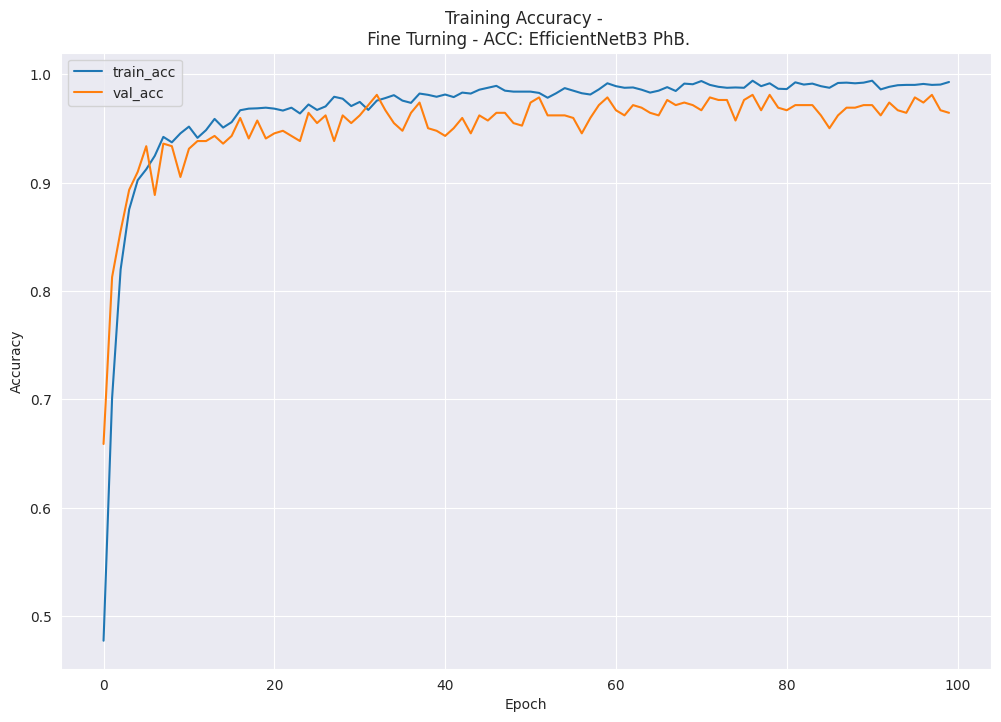

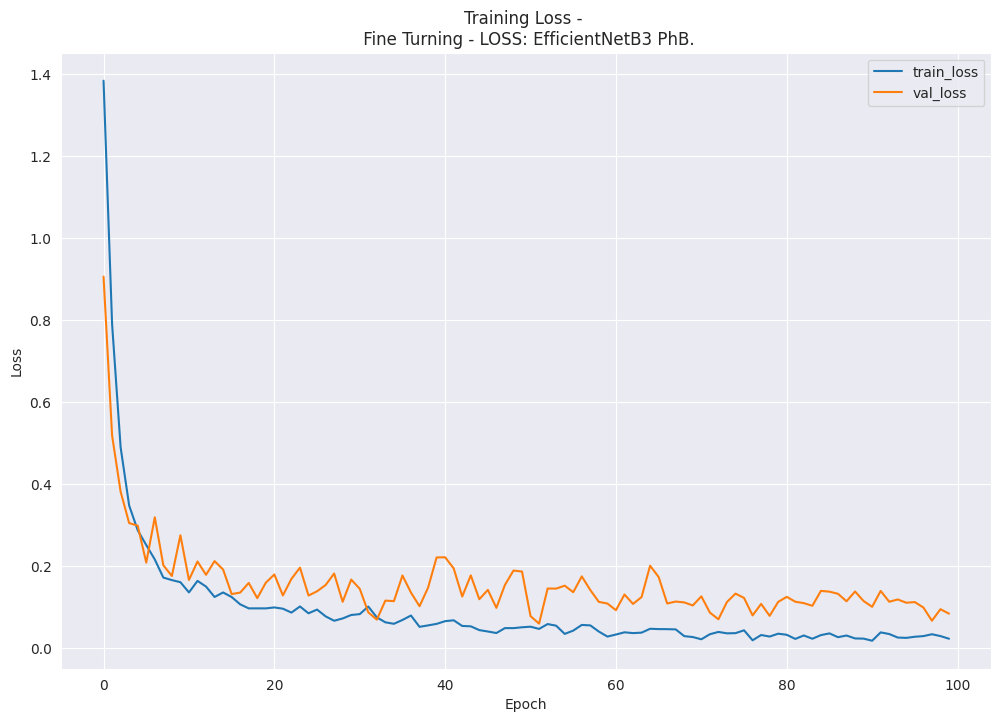

Visualize: y_true, y_pred top 20
Y_true [1, 4, 4, 3, 0, 1, 2, 3, 3, 4, 0, 4, 1, 1, 0, 4, 3, 0, 4, 3]
Y_pred [1, 4, 4, 3, 0, 1, 2, 3, 3, 4, 0, 4, 1, 1, 0, 4, 3, 0, 4, 3]
ACC:       0.966903073286052
Precision: 0.9670199011892459
Recall:    0.966903073286052
F1:        0.9668453094681164


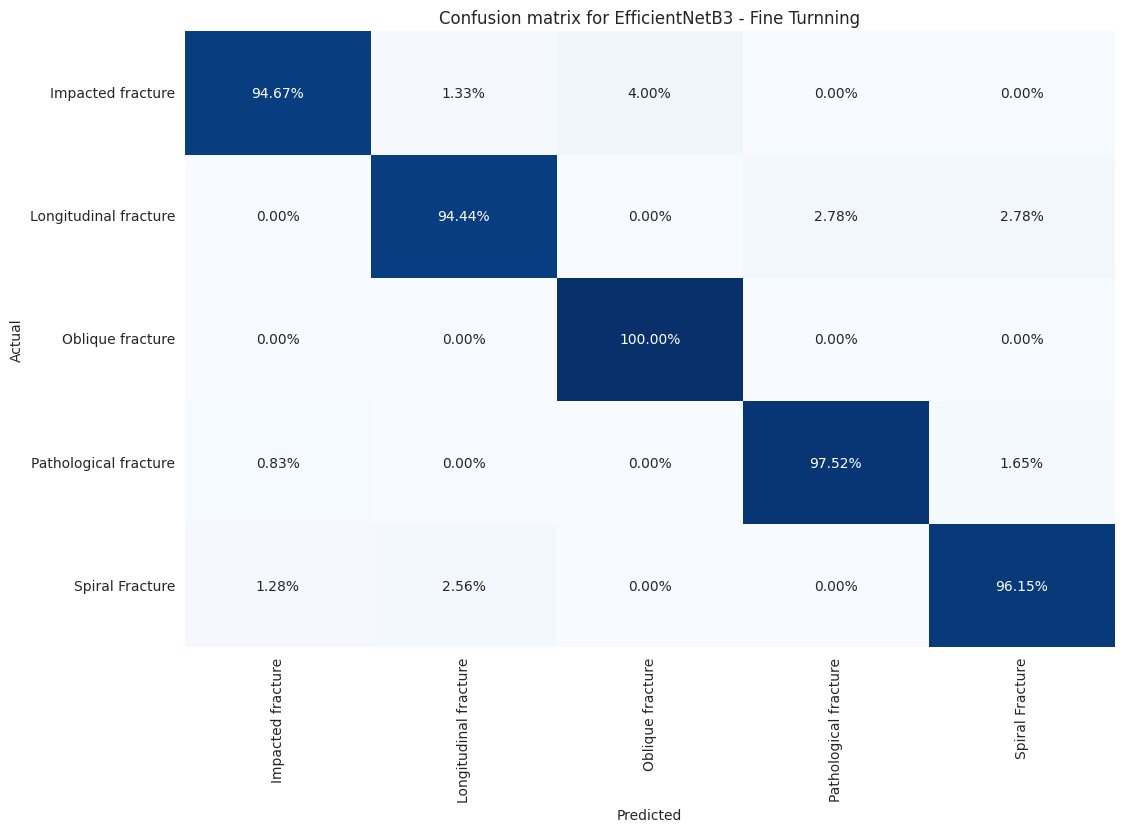

==========End Process with model EfficientNetB3==========




In [21]:
for name, Model in initial_models.items():
    
    base_model = Model(**initial_models_kwargs[name])
    for layer in base_model.layers:
        layer.trainable = False
        
    base_model.trainable = False
    output = base_model.layers[-1].output
    layers = [
        tf.keras.layers.BatchNormalization(),
        Dropout(0.2)
    ]
    
    if USE_HIDDEN_LAYERS:
        for layer in HIDDEN_LAYERS:
            layers.append(
                Dense(
                    layer, activation='relu', 
               )
             )
            layers.append(Dropout(0.1))
            layers.append(tf.keras.layers.BatchNormalization())
            
    layers.append(Dense(len(classes), activation='softmax'))
    
    for layer in layers:
        layer.trainable = True
        output = layer(output)
    
    model = tf.keras.models.Model(base_model.input, output, name=name)
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print(f'\n\n ==========Start Process with model {name}=========')
    model.summary()
    
    #history, model, best_acc_ph1, y_pred = transfer_learning(model, name)
    #calculate_metrics(y_test, y_pred)
    #cm = confusion_matrix(y_test, y_pred)
    #plot_confusion_matrix(cm, classes, title=f"Confusion matrix for {name} - Transfer Learning")
    
    #explaination_model(model)

    
    best_acc_ph1=0.85
    history, model, best_acc_ph2, y_pred = fine_turning(model, name, best_acc_ph1)
    calculate_metrics(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes, title=f"Confusion matrix for {name} - Fine Turnning")
        
    
    print(f'==========End Process with model {name}==========\n\n')

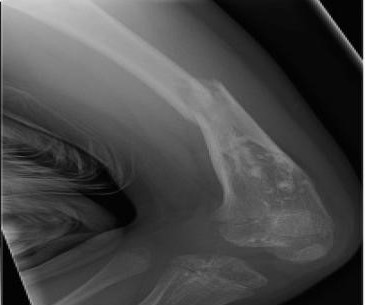

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from IPython.display import Image, display

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet_v2


# Size of the input image
img_size = (224, 224, 3)

# The local path to our target image
img_path = keras.utils.get_file("/kaggle/input/fracturefusion-a-symphony-of-bone-breaks/test/Pathological fracture/1-s2-0-S1877056815003461-gr6_jpg.rf.ad4975a23505ff95c659bf9b7319a.jpg","/kaggle/input/fracturefusion-a-symphony-of-bone-breaks/test/Pathological fracture/1-s2-0-S1877056815003461-gr6_jpg.rf.ad4975a23505ff95c659bf9b7319a.jpg")
display(Image(img_path))

In [23]:
def get_img_array(img_path, size=(224, 224)):
    # `img` is a PIL image of size 224
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 224, 224, 3)
    array = np.expand_dims(array, axis=0)
    return array


def get_gradients(img_input, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # 2. Preprocess the interpolated images
    interpolated_image = efficientnet_v2.preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


def random_baseline_integrated_gradients(
    img_input, top_pred_idx, num_steps=50, num_runs=2
):
    """Generates a number of random baseline images.

    Args:
        img_input (ndarray): 3D image
        top_pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(img_size) * 255
        igrads = get_integrated_gradients(
            img_input=img_input,
            top_pred_idx=top_pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)

In [24]:
class GradVisualizer:
    """Plot gradients of the outputs w.r.t an input image."""

    def __init__(self, positive_channel=None, negative_channel=None):
        if positive_channel is None:
            self.positive_channel = [0, 255, 0]
        else:
            self.positive_channel = positive_channel

        if negative_channel is None:
            self.negative_channel = [255, 0, 0]
        else:
            self.negative_channel = negative_channel

    def apply_polarity(self, attributions, polarity):
        if polarity == "positive":
            return np.clip(attributions, 0, 1)
        else:
            return np.clip(attributions, -1, 0)

    def apply_linear_transformation(
        self,
        attributions,
        clip_above_percentile=99.9,
        clip_below_percentile=70.0,
        lower_end=0.2,
    ):
        # 1. Get the thresholds
        m = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_above_percentile
        )
        e = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_below_percentile
        )

        # 2. Transform the attributions by a linear function f(x) = a*x + b such that
        # f(m) = 1.0 and f(e) = lower_end
        transformed_attributions = (1 - lower_end) * (np.abs(attributions) - e) / (
            m - e
        ) + lower_end

        # 3. Make sure that the sign of transformed attributions is the same as original attributions
        transformed_attributions *= np.sign(attributions)

        # 4. Only keep values that are bigger than the lower_end
        transformed_attributions *= transformed_attributions >= lower_end

        # 5. Clip values and return
        transformed_attributions = np.clip(transformed_attributions, 0.0, 1.0)
        return transformed_attributions

    def get_thresholded_attributions(self, attributions, percentage):
        if percentage == 100.0:
            return np.min(attributions)

        # 1. Flatten the attributions
        flatten_attr = attributions.flatten()

        # 2. Get the sum of the attributions
        total = np.sum(flatten_attr)

        # 3. Sort the attributions from largest to smallest.
        sorted_attributions = np.sort(np.abs(flatten_attr))[::-1]

        # 4. Calculate the percentage of the total sum that each attribution
        # and the values about it contribute.
        cum_sum = 100.0 * np.cumsum(sorted_attributions) / total

        # 5. Threshold the attributions by the percentage
        indices_to_consider = np.where(cum_sum >= percentage)[0][0]

        # 6. Select the desired attributions and return
        attributions = sorted_attributions[indices_to_consider]
        return attributions

    def binarize(self, attributions, threshold=0.001):
        return attributions > threshold

    def morphological_cleanup_fn(self, attributions, structure=np.ones((4, 4))):
        closed = ndimage.grey_closing(attributions, structure=structure)
        opened = ndimage.grey_opening(closed, structure=structure)
        return opened

    def draw_outlines(
        self,
        attributions,
        percentage=90,
        connected_component_structure=np.ones((3, 3)),
    ):
        # 1. Binarize the attributions.
        attributions = self.binarize(attributions)

        # 2. Fill the gaps
        attributions = ndimage.binary_fill_holes(attributions)

        # 3. Compute connected components
        connected_components, num_comp = ndimage.label(
            attributions, structure=connected_component_structure
        )

        # 4. Sum up the attributions for each component
        total = np.sum(attributions[connected_components > 0])
        component_sums = []
        for comp in range(1, num_comp + 1):
            mask = connected_components == comp
            component_sum = np.sum(attributions[mask])
            component_sums.append((component_sum, mask))

        # 5. Compute the percentage of top components to keep
        sorted_sums_and_masks = sorted(component_sums, key=lambda x: x[0], reverse=True)
        sorted_sums = list(zip(*sorted_sums_and_masks))[0]
        cumulative_sorted_sums = np.cumsum(sorted_sums)
        cutoff_threshold = percentage * total / 100
        cutoff_idx = np.where(cumulative_sorted_sums >= cutoff_threshold)[0][0]
        if cutoff_idx > 2:
            cutoff_idx = 2

        # 6. Set the values for the kept components
        border_mask = np.zeros_like(attributions)
        for i in range(cutoff_idx + 1):
            border_mask[sorted_sums_and_masks[i][1]] = 1

        # 7. Make the mask hollow and show only the border
        eroded_mask = ndimage.binary_erosion(border_mask, iterations=1)
        border_mask[eroded_mask] = 0

        # 8. Return the outlined mask
        return border_mask

    def process_grads(
        self,
        image,
        attributions,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
    ):
        if polarity not in ["positive", "negative"]:
            raise ValueError(
                f""" Allowed polarity values: 'positive' or 'negative'
                                    but provided {polarity}"""
            )
        if clip_above_percentile < 0 or clip_above_percentile > 100:
            raise ValueError("clip_above_percentile must be in [0, 100]")

        if clip_below_percentile < 0 or clip_below_percentile > 100:
            raise ValueError("clip_below_percentile must be in [0, 100]")

        # 1. Apply polarity
        if polarity == "positive":
            attributions = self.apply_polarity(attributions, polarity=polarity)
            channel = self.positive_channel
        else:
            attributions = self.apply_polarity(attributions, polarity=polarity)
            attributions = np.abs(attributions)
            channel = self.negative_channel

        # 2. Take average over the channels
        attributions = np.average(attributions, axis=2)

        # 3. Apply linear transformation to the attributions
        attributions = self.apply_linear_transformation(
            attributions,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            lower_end=0.0,
        )

        # 4. Cleanup
        if morphological_cleanup:
            attributions = self.morphological_cleanup_fn(
                attributions, structure=structure
            )
        # 5. Draw the outlines
        if outlines:
            attributions = self.draw_outlines(
                attributions, percentage=outlines_component_percentage
            )

        # 6. Expand the channel axis and convert to RGB
        attributions = np.expand_dims(attributions, 2) * channel

        # 7.Superimpose on the original image
        if overlay:
            attributions = np.clip((attributions * 0.8 + image), 0, 255)
        return attributions

    def visualize(
        self,
        image,
        predict_label,
        gradients,
        integrated_gradients,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
        figsize=(15, 8),
    ):
        # 1. Make two copies of the original image
        img1 = np.copy(image)
        img2 = np.copy(image)

        # 2. Process the normal gradients
        grads_attr = self.process_grads(
            image=img1,
            attributions=gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        # 3. Process the integrated gradients
        igrads_attr = self.process_grads(
            image=img2,
            attributions=integrated_gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        _, ax = plt.subplots(1, 3, figsize=figsize)
        ax[0].imshow(image)
        ax[1].imshow(grads_attr.astype(np.uint8))
        ax[2].imshow(igrads_attr.astype(np.uint8))

        ax[0].set_title("Original: "+ predict_label + ", Predict: "+ predict_label)
        ax[1].set_title("Normal gradients")
        ax[2].set_title("Integrated gradients")
        plt.show()

In [25]:
def decode_predictions_class(y_pred, top=5):
    """
    Decodes predictions for a 4-class classification problem.

    Args:
      y_pred: A numpy array of shape (num_samples, num_classes) containing
          predicted probabilities.
      top: (int) number of top predictions to return.

    Returns:
      A list of lists containing the top `top` predictions for each sample.
      Each inner list contains a tuple of (class_name, probability).
    """
    # Get class indices and probabilities
    class_indices = np.argsort(y_pred, axis=-1)[:, -top:][:, ::-1]
    probabilities = y_pred[np.arange(len(y_pred))[:, None], class_indices]

    # Define your class labels (modify these as needed)
    class_labels = classes

    # Create the list of predictions
    predictions = []
    for sample_preds, sample_probs in zip(class_indices, probabilities):
        predictions.append([(class_labels[i], prob) for i, prob in zip(sample_preds, sample_probs)])

    return predictions

In [26]:
# 1. Convert the image to numpy array
img = get_img_array(img_path)

# 2. Keep a copy of the original image
orig_img = np.copy(img[0]).astype(np.uint8)

# 3. Preprocess the image
img_processed = np.expand_dims(img[0],axis=0)

# 4. Get model predictions
preds = model.predict(img_processed)
print(preds)
top_pred_idx = tf.argmax(preds[0])
print("Predicted:", top_pred_idx, decode_predictions_class(preds, top=1)[0])

# 5. Get the gradients of the last layer for the predicted label
grads = get_gradients(img_processed, top_pred_idx=top_pred_idx)

# 6. Get the integrated gradients
igrads = random_baseline_integrated_gradients(
    np.copy(orig_img), top_pred_idx=top_pred_idx, num_steps=50, num_runs=4
)

# 7. Process the gradients and plot
vis = GradVisualizer()
predict_label = decode_predictions_class(preds, top=1)[0][0][0]

1/1 [==============================] - 1s 938ms/step
[[9.8875207e-06 2.6713698e-07 1.0194898e-03 7.1774930e-01 2.8122106e-01]]
Predicted: tf.Tensor(3, shape=(), dtype=int64) [('Pathological fracture', 0.7177493)]


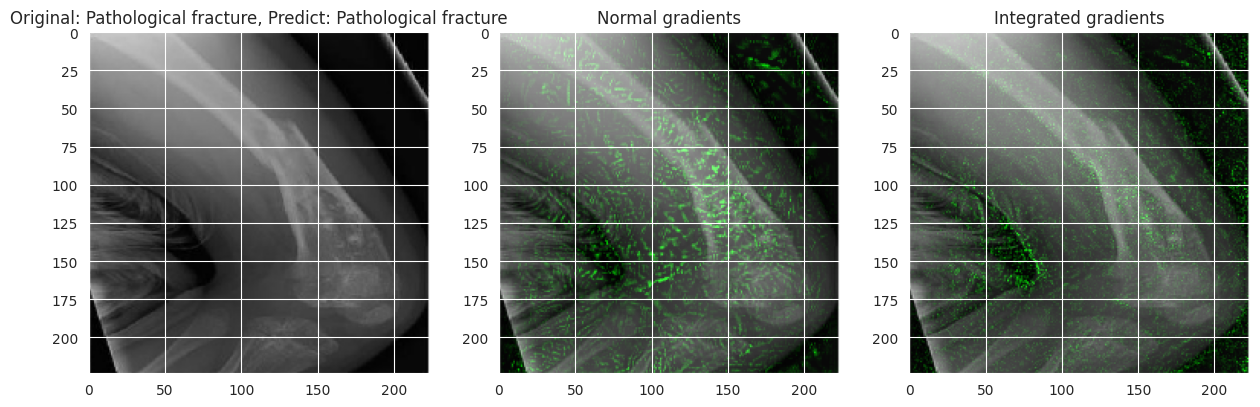

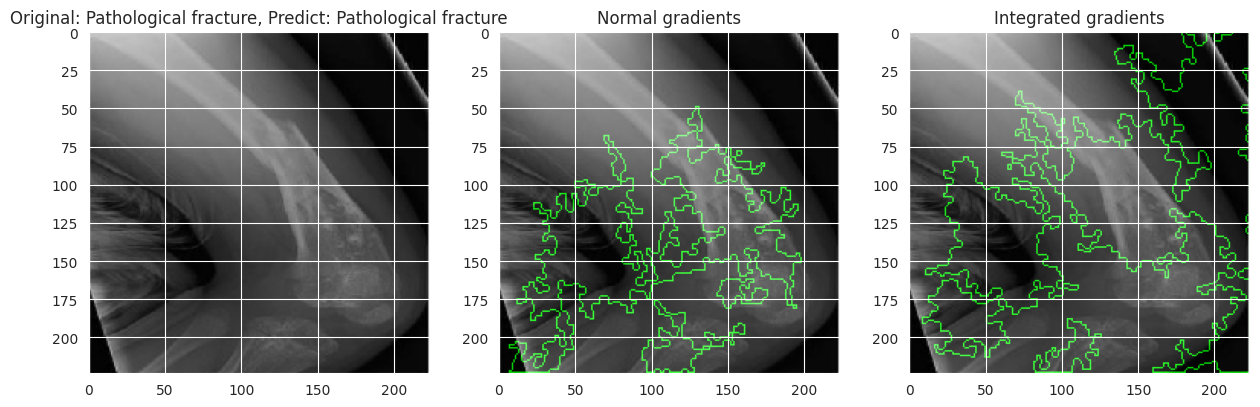

In [27]:
vis.visualize(
    image=orig_img,
    predict_label=predict_label,
    gradients=grads[0],
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=99,
    clip_below_percentile=0,
)

vis.visualize(
    image=orig_img,
    predict_label=predict_label,
    gradients=grads[0],
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=95,
    clip_below_percentile=28,
    morphological_cleanup=True,
    outlines=True,
)